In [1]:
import os
import re
import numpy as np
from sklearn.metrics import confusion_matrix

import torch
from torch.nn import MaxPool1d

import matplotlib.pyplot as plt

In [2]:
dir_name = "causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop"
files_dir = "/Volumes/UBUNTU 18_0/PAKOVA/outputs/" + dir_name

result_files = sorted([os.path.join(files_dir, f) for f in os.listdir(files_dir) if f.endswith('.txt')])

split_text = []
for fid, fname in enumerate(result_files):
    print(fname)
    with open(fname, 'r', encoding ="ISO-8859-1") as infile:
#         a = infile.readline()
#         print(a)
        for line in infile:
            split_text.append(line.strip().split('|'))

/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop_0.txt
/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop_1.txt
/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop_2.txt
/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop_3.txt
/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop_4.txt
/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop/causal_eval_kinetics_r50_i3d_baseline32_stream_centerCrop_5.txt
/Volumes/UBUNTU 18_0/PAKOVA/outputs/causal_eval_kine

In [3]:
split_text[0]

['driving_tractor/cn2OQeIdLcw.mp4_000089 ',
 ' 104 ',
 ' 104 103 199 261 372 ',
 ' 9.5891321e-01 3.2198835e-02 1.9693538e-03 1.9635737e-03 6.4844702e-04']

In [4]:
split_text2 = []
for i, line in enumerate(split_text):
    if len(line) == 1:
        aux = split_text2[-1][-1].replace(line[0], '') + ' ' + line[0]
        preds = np.fromstring(aux, dtype=float, sep=' ')
        split_text2[-1][-1] = aux
        
    elif len(line) == 4:
        split_text2.append(line)
    else:
        print(line)
        
%xdel split_text
split_text = split_text2

In [5]:
def get_full_predictions(ids, preds, num_classes=400):
    full_preds = np.zeros((num_classes))
    full_preds[ids] = preds
    return full_preds


def divide_per_clip(split_text):
    clips_targets = []
    clips_prediction = []

    video_name = None
    for i, [video_path, target, label, pred] in enumerate(split_text):
        video = re.sub('()_\\d{6}', '', video_path.strip())
        if video != video_name or i == len(split_text):            
            # new video! But first, save old video
            if i > 0:
                video_targets = np.array(video_targets)
                video_prediction = np.array(video_prediction)
                
                num_frames = video_prediction.shape[0]
                if num_frames < 10:
                    repeat_ids = np.round(np.linspace(0, num_frames - 1, 10)).astype(int)
                    video_targets = video_targets[repeat_ids]
                    video_prediction = video_prediction[repeat_ids]
                    
                clips_targets.append(video_targets)
                clips_prediction.append(video_prediction)
                    
            # star new one
            video_targets = []
            video_prediction = []
            video_name = video
            
        video_targets.append(int(target))
        labels = np.fromstring(label, dtype=int, sep=' ')
        preds = np.fromstring(pred, dtype=float, sep=' ')
        video_prediction.append(get_full_predictions(labels, preds))
                
    return clips_targets, clips_prediction

def select_n_clips(video_classes, n=10):
    num_frames = len(video_classes)
    ids = np.linspace(0, num_frames-1, n, dtype=int)
    
    return video_classes[ids]


In [6]:
# Dividing per clip
clip_targets, clip_pred = divide_per_clip(split_text)


# Getting result of 10 clips
clip_pred_10 = [select_n_clips(np.array(clip_data), n=10) for clip_data in clip_pred]

clip_pred_10_mean = np.array([t_c.mean(axis=0) for t_c in clip_pred_10])
clip_gt_10 = np.array([clip_data[0] for clip_data in clip_targets])


# Dividing all frames in percentages
p_clip_targets = np.array([np.array_split(ct, 10) for ct in clip_targets])
p_clip_pred = np.array([np.array_split(cp, 10) for cp in clip_pred])


In [7]:
num_videos = p_clip_targets.shape[0]
num_percent = p_clip_targets.shape[1]
num_topk = 5

percentage_targets = np.zeros((num_videos, num_percent))
percentage_pred = np.zeros((num_videos, num_percent, num_topk))

for clip_id, (p_targets, p_preds) in enumerate(zip(p_clip_targets, p_clip_pred)):
    for p_id in range(10):
        pt = np.hstack(p_targets[:p_id+1])
        pp = np.vstack(p_preds[:p_id+1])
        assert len(set(pt)) == 1  # Checking if all targets match
        percentage_targets[clip_id, p_id] = pt[0]
        preds = torch.tensor(pp)
        mean_pp = preds.mean(0)
        _, topk_labels = torch.topk(mean_pp, 5)
        percentage_pred[clip_id, p_id] = topk_labels.numpy()


In [8]:
def get_top_predictions(video_pred, video_labels):
    # TOP1
    top1_pred = [p[0] for p in video_pred]
    # TOP 5
    top5_pred = []
    for l, p in zip(video_labels, video_pred):
        if l in p:
            top5_pred.append(l)
        else:
            top5_pred.append(p[0])
    return top1_pred, top5_pred


def per_class_accuracy(predictions, labels):
    cf = confusion_matrix(labels, predictions).astype(float)

    cls_cnt = cf.sum(axis=1)
    cls_hit = np.diag(cf)
    return np.nanmean(cls_hit / cls_cnt)


def get_per_frame_percent_results(p_targets, p_preds):
    per_frame_percentage_results = []
    for p_id in range(10):
        p_t = p_targets[:, p_id]
        p_p = p_preds[:, p_id]
        top1_pred, top5_pred = get_top_predictions(p_p, p_t)

        cls_acc1 = per_class_accuracy(top1_pred, p_t)
        cls_acc5 = per_class_accuracy(top5_pred, p_t)
        per_frame_percentage_results.append([cls_acc1, cls_acc5])
        print((p_id+1)*10, cls_acc1, cls_acc5)
    return np.array(per_frame_percentage_results)

In [9]:
# 10 clips results

clip_top5_10 = []
for mean_10 in clip_pred_10_mean:
    _, topk_labels = torch.topk(torch.tensor(mean_10), 5)
    clip_top5_10.append(topk_labels.numpy())
    
clip_top5_10 = np.array(clip_top5_10)

top1_pred, top5_pred = get_top_predictions(clip_top5_10, clip_gt_10)

cls_acc1_10 = per_class_accuracy(top1_pred, clip_gt_10)
cls_acc5_10 = per_class_accuracy(top5_pred, clip_gt_10)

cls_acc1_10, cls_acc5_10

(0.7185444134220279, 0.8981104859794251)

In [10]:
# All frames mean percentage results

per_frame_percent_res = get_per_frame_percent_results(percentage_targets, percentage_pred)

10 0.6353071784240987 0.842143346882105
20 0.6496236937896708 0.8553466583120087
30 0.6685064012268491 0.8693839630136247
40 0.6844687167016332 0.8794898296263814
50 0.6950135009090818 0.8869802328949548
60 0.7006409484355512 0.8936468366055109
70 0.7076723353907903 0.8967922245656595
80 0.7133073432586948 0.8983076085400101
90 0.7160343696726581 0.899885452305975
100 0.7195033363357255 0.9000551723738021


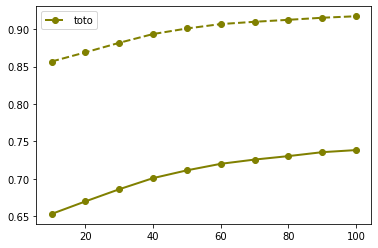

In [74]:
y = np.arange(10, 110, 10)

plt.plot(y, per_frame_percent_res[:, 0], marker='o', color='olive', linewidth=2, label="")
plt.plot(y,per_frame_percent_res[:, 1], marker='o', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.legend()

In [11]:
results = np.concatenate((np.array([[cls_acc1_10, cls_acc5_10]]), per_frame_percent_res))

In [12]:
output_file = files_dir + '_results'
np.save(output_file, results, allow_pickle=False)

In [13]:
results_baseline32_centerCrop = np.load(output_file+'.npy')

In [14]:
results_baseline32_centerCrop

array([[0.71854441, 0.89811049],
       [0.63530718, 0.84214335],
       [0.64962369, 0.85534666],
       [0.6685064 , 0.86938396],
       [0.68446872, 0.87948983],
       [0.6950135 , 0.88698023],
       [0.70064095, 0.89364684],
       [0.70767234, 0.89679222],
       [0.71330734, 0.89830761],
       [0.71603437, 0.89988545],
       [0.71950334, 0.90005517]])

In [14]:
results_nl32_centerCrop

array([[0.73355357, 0.91071791],
       [0.65183775, 0.85287248],
       [0.66693359, 0.8672611 ],
       [0.6822416 , 0.87995986],
       [0.69564461, 0.89168807],
       [0.7076758 , 0.89937124],
       [0.71635096, 0.90316556],
       [0.72185032, 0.90700233],
       [0.72674467, 0.9100338 ],
       [0.73233295, 0.91069292],
       [0.73417942, 0.91145335]])

In [89]:
results_nl8_centerCrop

array([[0.73935215, 0.91784009],
       [0.65289267, 0.85684554],
       [0.66969472, 0.86911939],
       [0.68593682, 0.88189664],
       [0.70082018, 0.89361338],
       [0.711213  , 0.90102226],
       [0.71994408, 0.90694043],
       [0.7256107 , 0.90999549],
       [0.73025136, 0.91263238],
       [0.73550584, 0.91540209],
       [0.73831541, 0.91741199]])